In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from sklearn import preprocessing, cross_validation, neighbors

# AW_online ist das aktuelle Auswertung.JSON auf GitHub
AW_online = requests.get('https://raw.githubusercontent.com/computational-humanities/topoi/master/projects/sundials/Auswertung.json')
data = AW_online.json()

In [2]:
# Funktion um Zahlenstrings in Floats umzuwandeln und 'unknown'-Werte im JSON in None-Werte umzuformen
def ToNum(number):
    try:
        return float(number)
    except:
        return None 

In [3]:
# Auslesen der G-, S- und ObjID-Werte aus dem JSON
Gw = [x['Gw'] for x in data]
Ge = [x['Ge'] for x in data]
Sw = [x['Sw'] for x in data]
Se = [x['Se'] for x in data]
ObjID = [x['ObjID'] for x in data]

In [4]:
# Erstellen von G- und S-Durchschnittswertlisten
Glist=[]
for i in range(0,len(Gw)):
    Gwerte = [ToNum(Gw[i]), ToNum(Ge[i])]
    if Gwerte == [None, None]:        
        Glist.append('unknown')
    elif Gwerte[0] == None:
        Glist.append(Gwerte[1])
    elif Gwerte[1] == None:
        Glist.append(Gwerte[0])
    else:
        Glist.append(mean(Gwerte))
        
Slist=[]
for i in range(0,len(Sw)):
    Swerte = [ToNum(Sw[i]), ToNum(Se[i])]
    if Swerte == [None, None]:        
        Slist.append('unknown')
    elif Swerte[0] == None:
        Slist.append(Swerte[1])
    elif Swerte[1] == None:
        Slist.append(Swerte[0])
    else:
        Slist.append(mean(Swerte))

In [5]:
# Erstellen einer Gesamtliste GSO, löschen aller verbleibenden 'unknown'- Werte, Aufspaltung der Liste in verwertbare Einzellisten
GSO = [x for x in list(map(list, zip(*[Glist,Slist,ObjID]))) if not 'unknown' in x]
G_average = [x[0] for x in GSO]
S_average = [x[1] for x in GSO]
GS_ObjIDs = [x[2] for x in GSO]

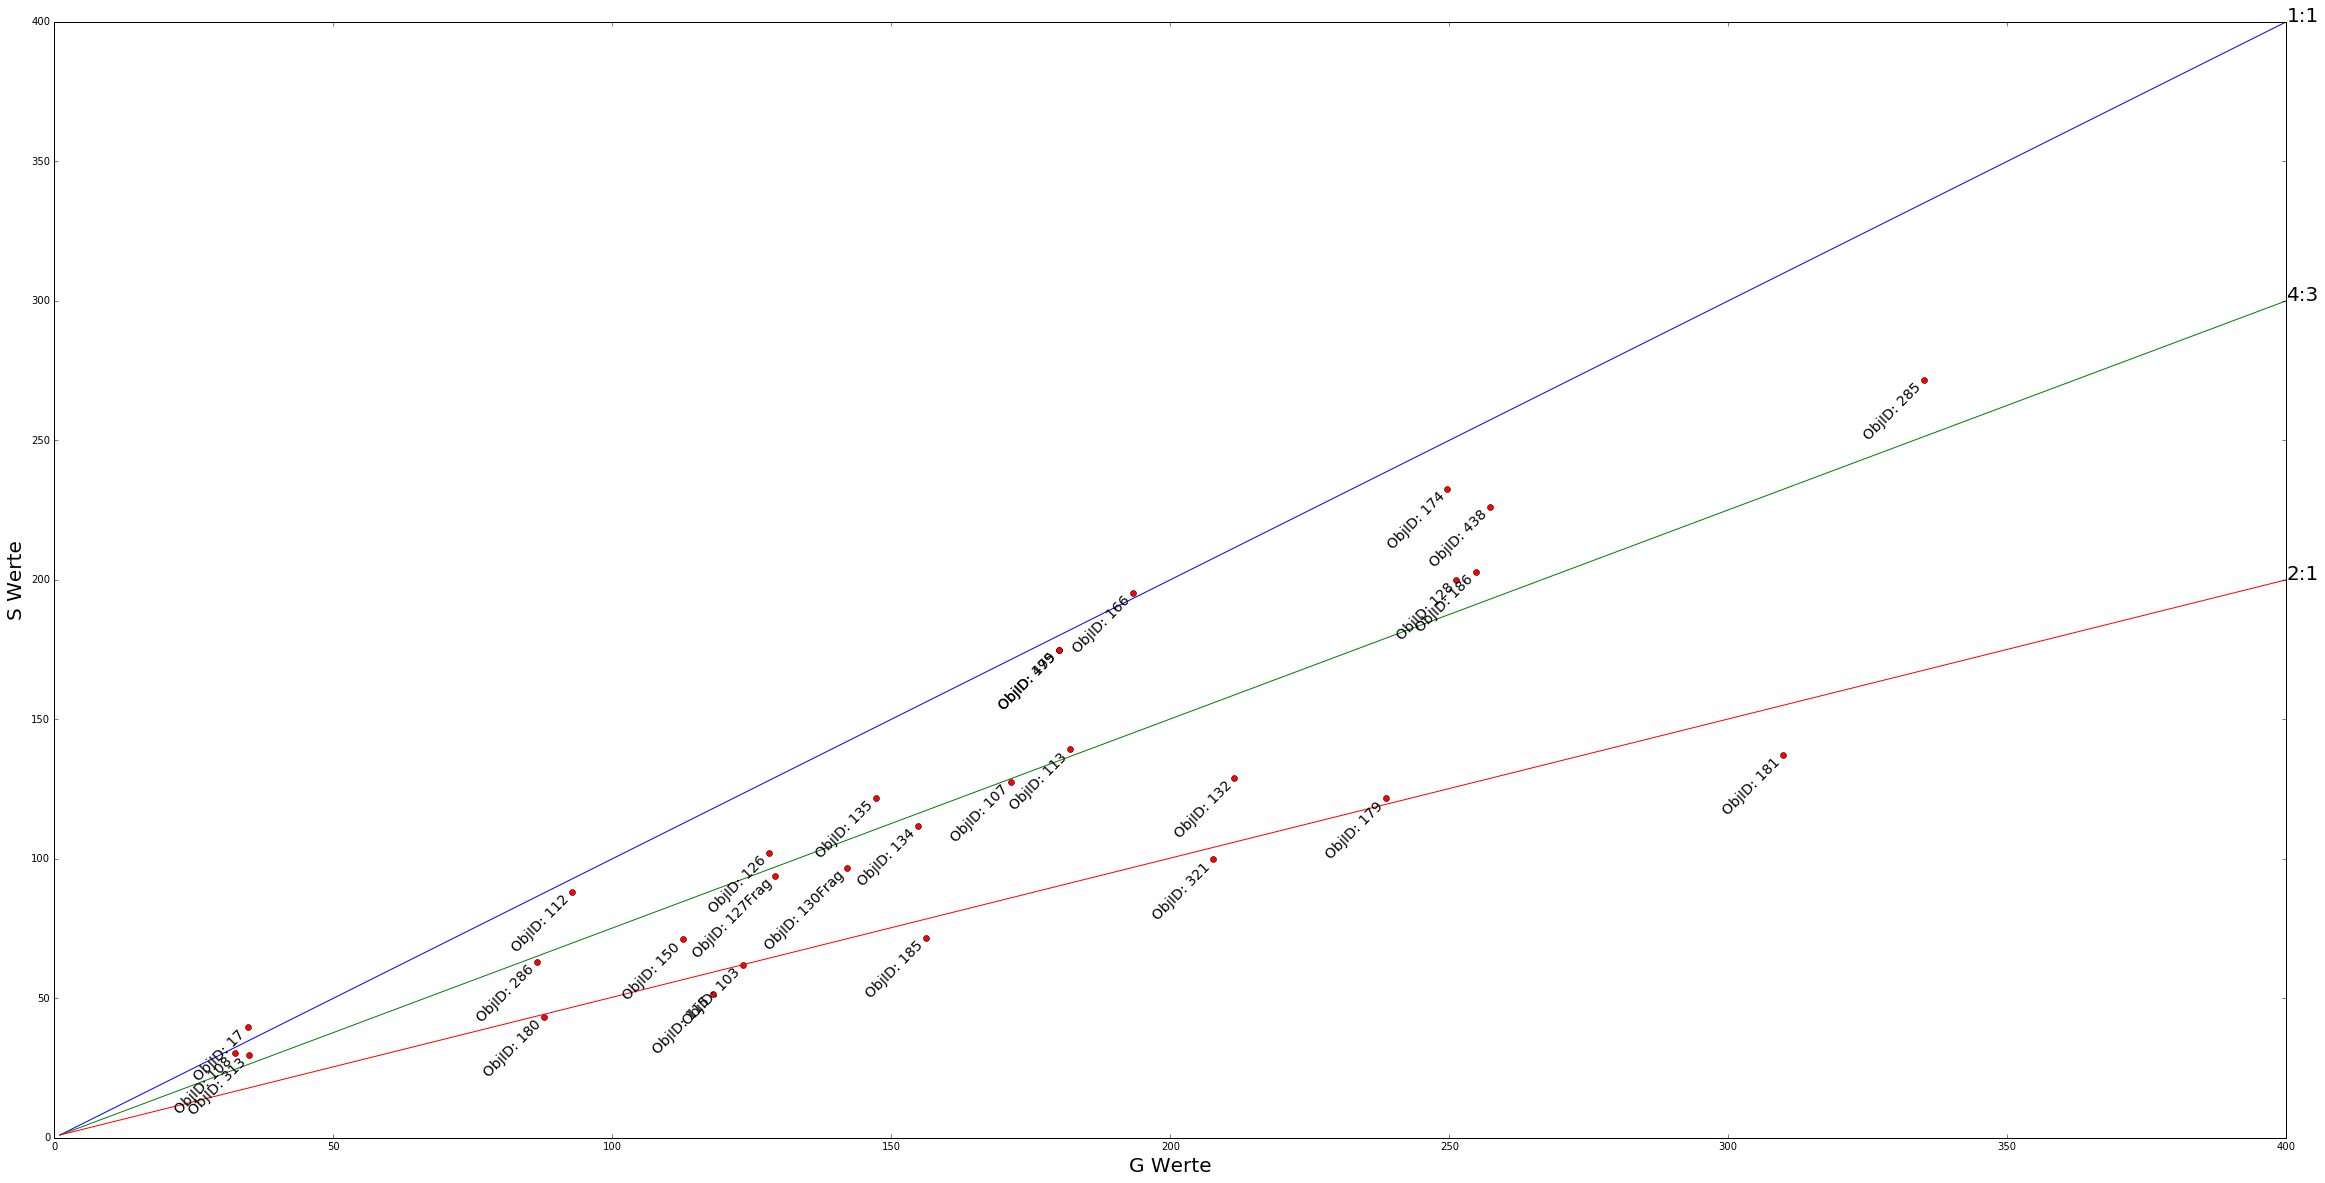

In [6]:
# Plot der G-und S-Punkte mit ObjID sowie 3er Verlgeichslinen 
%matplotlib inline
fig, ax = plt.subplots(figsize=(40,20))

ax.plot([G_average],[S_average],'ro')
ax.plot([1,400],[1,400])
ax.plot([1,400],[1,300])
ax.plot([1,400],[1,200])

plt.xlabel('G Werte',size=20)
plt.ylabel('S Werte',size=20)

ax.annotate('1:1' , xy=(400,400),size=20)
ax.annotate('4:3' , xy=(400,300),size=20)
ax.annotate('2:1' , xy=(400,200),size=20)
for i, txt in enumerate(GS_ObjIDs):
    ax.annotate('ObjID: ' + txt, (G_average[i],S_average[i]),size=14,va="top", ha="right" ,rotation=45)

plt.show()

In [8]:
# Funktion um Verältnisnummerierungen in lesbare Strings umzuwandeln
def verh(number):
    if number == 1:
        return '1:1'
    elif number == 2:
        return '4:3'
    elif number == 3:
        return '1:2'
    else:
        return 'unknown'

# Das trainset besteht aus jeweils 500 Punkten auf den oben eingezeichneten Geraden
trainset = list([x, x, 1] for x in list(range(500))) + list([x, 3*x/4, 2] for x in list(range(500))) + list([x, 1/2*x, 3] for x in list(range(500)))
df = pd.DataFrame(trainset)

# Definition der zu untersuchenden Variablen in X(S- und G- Werte) sowie der zugehörigen Klassen in y
X = np.array(df.drop([2],1))
y = np.array(df[2])

# Definition des Classifiers und Trainieren des Algorithmus
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

clf = neighbors.KNeighborsClassifier()
clf.fit(X_train, y_train)

# Festlegen des Testsets (GSO) und Ausgabe der Verhätnisklassen
testset = np.array(list(x[:2] for x in GSO))
testset = testset.reshape(len(list(x[:2] for x in GSO)),-1)

prediction = clf.predict(testset)

# Ausgabe als sortierte Tabelle inclusive ObjIDs
pred = list(prediction)
GSOnew = []
for a,b in zip(GSO,pred):
    GSOnew.append([a[2],a[0],a[1],verh(b)])

GSO_new = pd.DataFrame(GSOnew)
GSO_new.columns = ['ObjID','G','S','Verhältnis']
GSO_new.sort_values(['Verhältnis','ObjID'])

,ObjID,G,S,Verhältnis
22,108,32.43060,30.23145,1:1
24,112,92.79350,87.98080,1:1
12,166,193.33250,195.16900,1:1
23,17,34.67135,39.56995,1:1
9,174,249.65700,232.47050,1:1
10,175,180.09900,175.00500,1:1
13,438,257.23550,226.15100,1:1
11,499,180.09900,175.00500,1:1
27,103,123.33000,62.03370,1:2
28,115,118.06900,51.64940,1:2


In [13]:
#Prediction eines einzelnen Wertes
#Form: test = [[G-Wert, S-Wert, ObjID]]

In [11]:
test = [[250, 150, 100]]

In [16]:
testset = np.array(list(x[:2] for x in test))
testset = testset.reshape(len(list(x[:2] for x in test)),-1)

prediction = clf.predict(testset)

# Ausgabe als sortierte Tabelle inclusive ObjIDs
pred = list(prediction)
Ausgabe = []
for a,b in zip(test,pred):
    Ausgabe.append([a[2],a[0],a[1],verh(b)])

Ausg = pd.DataFrame(Ausgabe)
Ausg.columns = ['ObjID','G','S','Verhältnis']
Ausg

,ObjID,G,S,Verhältnis
0,100,250,150,1:2
